In [1]:
bayesplay::loadpackages()

# Regression

I'm going to assume that everyone doing this course is already pretty familiar with regression, so it's not my intention to re-cover stuff that you already know. Instead, I thought it would be useful to step through a few simple examples of Bayesian estimation of regression models to highlight some of the mechanics. Some of the examples used in this section are adapted from Richard McElreath's fantastic book [Statistical Rethinking](https://www.crcpress.com/Statistical-Rethinking-A-Bayesian-Course-with-Examples-in-R-and-STAN/McElreath/p/book/9780367139919) which I cannot recommend highly enough.

## Over-fitting and under-fitting

When we build statistical models, like regression models, what we're aiming to do is to model some underlying data generating process—our aim is **NOT** to find that best curve that fits through the data points, or at least it shouldn't be!

If our aim **was** just to get the best fit to data then it would be trivially easy to do. For any case where we have $n$ data points will be able to provide a prefect fit just by adding more predictors—the simplest case of this is when we employ a polynomial fit (i.e, $\mathrm{y} = \alpha + \beta{}\mathrm{x}^1 + \beta{}\mathrm{x}^2... + \beta{}\mathrm{x}^{n-1}$). We can see this in the example below. By progressively adding more predictors (additional terms of $x^i$) you can see that the curve starts to match the data points more and more closely. The $R^2$ will eventually reach 1 when we add enough predictors.

Warning message in qt((1 - level)/2, df):
“NaNs produced”


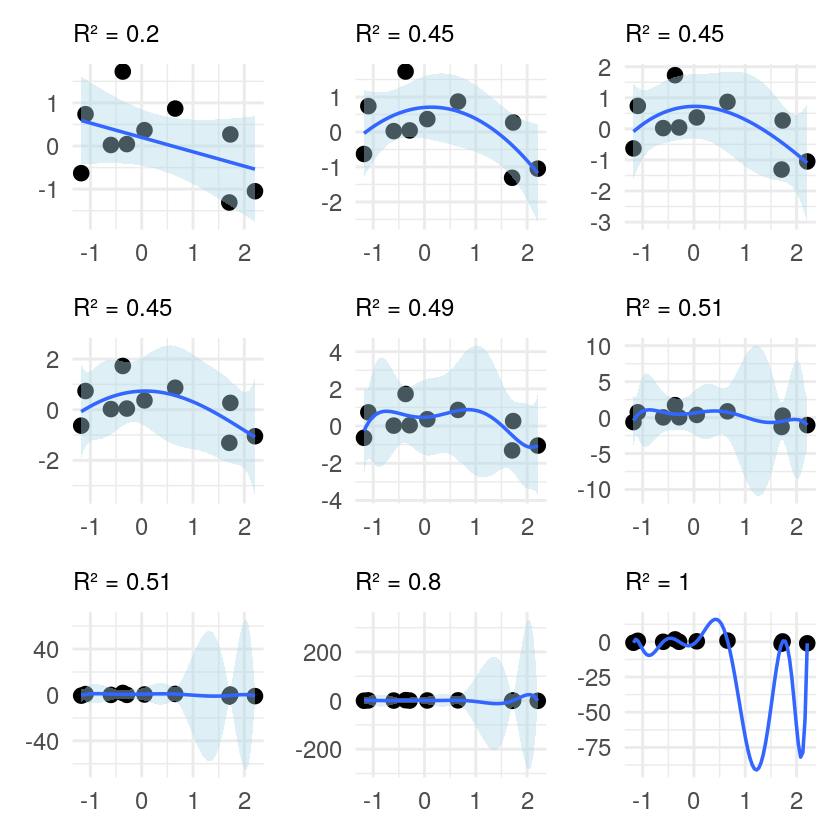

In [2]:
# 1

# make some random data!
set.seed(6)
d = matrix(rnorm(n = 20), ncol = 2)
d = d %>% set_colnames(c("Y","X")) %>% as_tibble()



r.square.list = function(d,x.terms){
    x.terms = 1:x.terms
    coeffs = glue::glue("I(X^{x.terms})") %>% paste0(collapse = " + ")
    formula = glue::glue("Y ~ {coeffs}")
    r.squared = suppressWarnings({summary(lm(formula = formula, d))$r.squared %>% round(2)})
    return(r.squared)
    }


r.squares = map(1:9, function(x) r.square.list(d,x))
fit_plots = suppressWarnings({map(1:9, function(I) ggplot(data = d, aes(x = X, y = Y)) + 
    geom_point(size = 4) + geom_smooth(method = "lm", formula = y ~ poly(x,I), na.rm = F, fill = "lightblue") + 
theme_minimal(18) + labs(title = glue::glue("R² = {r.squares[I]}"), x = NULL, y = NULL) +
theme(title = element_text(size = 12)))})

# make sequence of plot adding a new term each time
wrap_plots(fit_plots)

If we remove all the predictors (so we only have the intercept) you'll see that now the line is only dependent on $\mathbf{y}$ and not $\mathbf{x}$. 


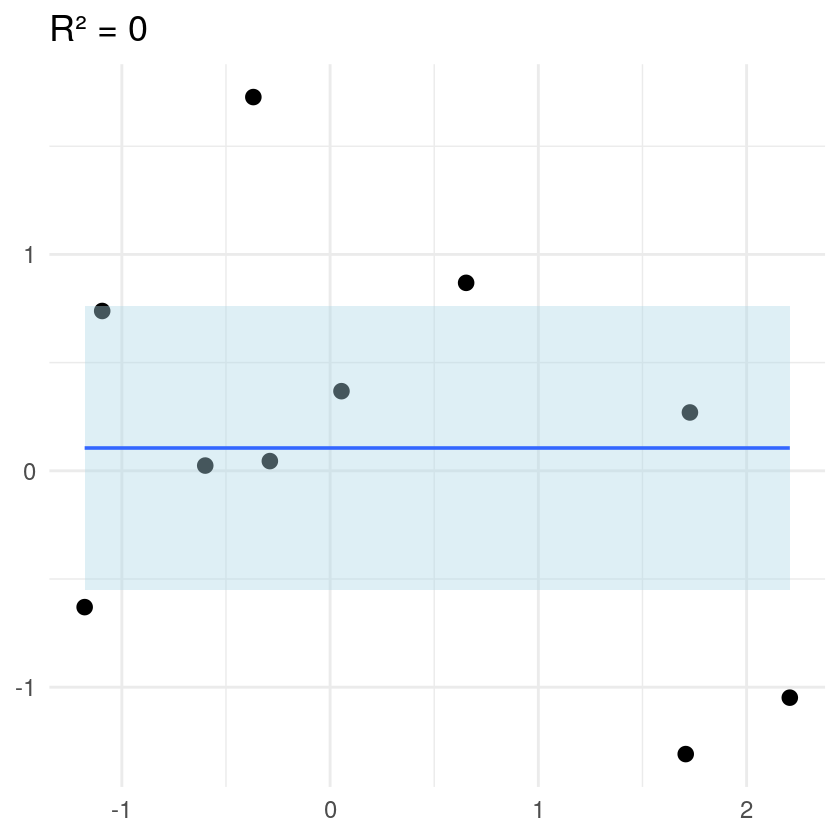

In [3]:
# 2
ggplot(data = d, aes(x = X, y = Y)) + 
    geom_point(size = 4) + geom_smooth(method = "lm", formula = y ~ 1, na.rm = F, fill = "lightblue") + 
theme_minimal(18) + labs(title = "R² = 0", x = NULL, y = NULL)


Again, if our aim is to model the **data generating process** rather than the **data itself** then over-fitting will be bad because it will be to **sensitive** to the data we have at hand. In contrast, when we **under-fit** then your model will be to **insensitive**. We can see this by looking at the predictions generated by **under-fit** and **over-fit** models.

In the plots below, I simply remove **one** data point and then refit the model with **9** predictors (panel A) or model where we only have **1** predictor (panel B).

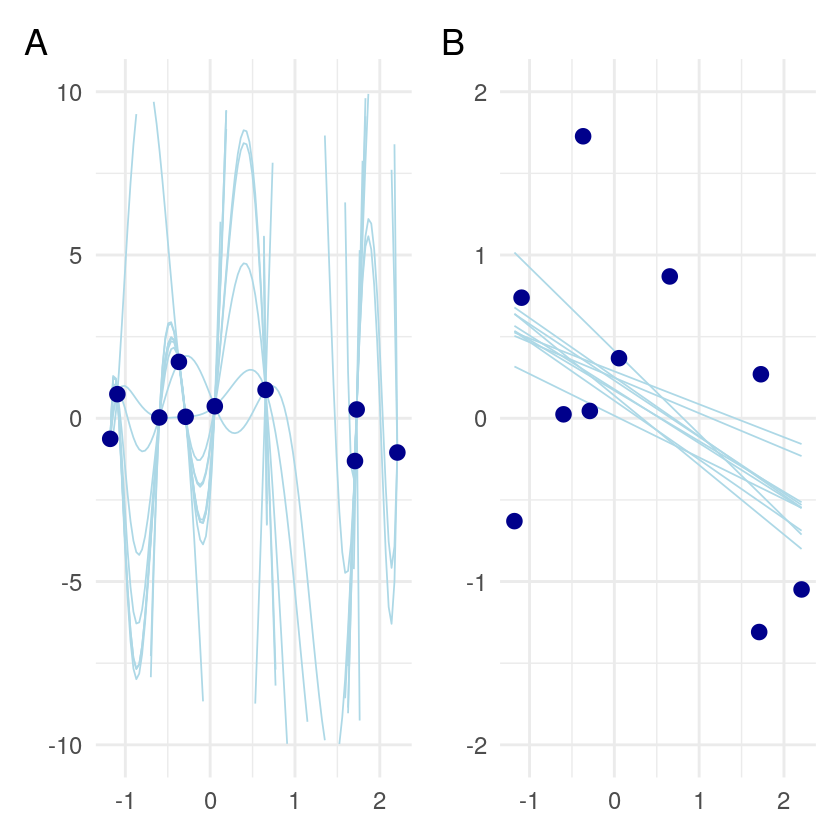

In [4]:
# 3
points = map(1:10, function(x) which((1:10 %in% x)==FALSE))
             
underfit = map_df(1:10, function(x) suppressWarnings({d %>% slice(points[[x]]) %>% lm(Y ~ 1 + X, data = .) %>% 
    predict(newdata = tibble(X = seq(min(d$X),max(d$X), length.out = 100))) %>% 
    enframe(value = "Y") %>% mutate(set = x, X =  seq(min(d$X),max(d$X), length.out = 100))}))

overfit = map_df(1:10, function(x) suppressWarnings({d %>% slice(points[[x]]) %>% 
                 lm(Y ~ 1 + I(X^1) + I(X^2) + I(X^3) + I(X^4) + I(X^5) + I(X^6) + I(X^7) + I(X^8) + I(X^9), data = .) %>% 
    predict(newdata = tibble(X = seq(min(d$X),max(d$X), length.out = 100))) %>% 
    enframe(value = "Y") %>% mutate(set = x, X =  seq(min(d$X),max(d$X), length.out = 100))}))


overfit_plot = ggplot() + geom_line(data = overfit, aes(x = X, y = Y, group = set), na.rm = T, colour = "lightblue") +
geom_point(data = d, mapping = aes(x = X, y = Y), size = 4, colour = "darkblue") + theme_minimal(18) +
labs(x = NULL, y = NULL) + lims(y = c(-10,10))

underfit_plot = ggplot() + geom_line(data = underfit, aes(x = X, y = Y, group = set), na.rm = T, colour = "lightblue") +
geom_point(data = d, mapping = aes(x = X, y = Y), size = 4, colour = "darkblue") + theme_minimal(18) +
labs(x = NULL, y = NULL) + lims(y = c(-2,2))

overfit_plot + underfit_plot + plot_annotation(tag_levels = "A")

You can see that in panel A the predictions (blue lines) changes **wildly** whereas the predictions in panel B hardly change at all. From this, we can see that for any case in panel A, when we add the additional data point, it will fall way outside of the prediction generated by the model. This means we haven't captured the data generating process. Whenever we have *two or more* **candidate** models we can see which does a better a job of capturing the underlying data generating processing by comparing which model does a better job of accommodating **new data**. This means that one of the main goals in regression is to find the right balance between **over-fitting** and **under-fitting**. 

 Many of you will already be familiar with techniques such as LASSO regression, metrics such as adjusted $R^2$, model comparison approaches using AIC, or procedures like cross-validation. The aim of all of these is to find that balance between over-fitting and under-fitting. 

The aim of this section is to understand what tools are available to you once you decide to go Bayesian with your regression models. 



# Model performance 

One commonly used metric of model performance is the model **deviance**. Deviance simply tells us about model fit—specifically, it tells us about how likely the observed data are given the model parameters. 

Just to recap what we're trying to do with regression. When we have data a vector of $\mathrm{y}$ and vector of predictors $\mathrm{x}$, we're just trying to capture that relationship with a distributional model (i.e., a likelihood) with a mean and residual variance (a simple linear regression) such as the following:

$$y_i \sim Normal(\alpha + \beta{}x_i,\sigma)$$

So the parameters that maximise the likelihood of the data are the parameters we choose. And we know that the likelihood for a $n$ independent events is going to be:

$$\prod_{i=1}^n\mathcal{L}(x_i|\alpha + \beta{}x_i,\sigma)$$

One way to access model fit is just to take the $\mathrm{log}$ of this. This gives us the log likelihood of the model and our data. To calculate the log Likelihood of a model fit, we can just use the `logLik` function in **R**, or we can do it by hand!


In [5]:
# 4

# make some data
n = 20
df = tibble(X = rnorm(n,  0, 1),
                Y = rnorm(n , 0, 1))

# fit the model
fit = lm(Y ~ 1 + X, df)

#  # extract model parameters
   
alpha = fit$coefficients[[1]] # alpha
beta = fit$coefficients[[2]] # beta

rse.ols = summary(fit)$sigma # get the ols sigma
sigma = rse.ols  * sqrt((n - ncol(df))/n) # convert it to the mle sigma

# define the distribition 

liks = dnorm(x = df$Y, mean = alpha + beta * df$X, sd = sigma)
logLik_val = log(prod(liks))


glue::glue("Our hand calculated log likelihood is {round(logLik_val,2)}   
The one calculated by **R** is {round(logLik(fit),2)}") %>%
IRdisplay::display_markdown()

Our hand calculated log likelihood is -25.05   
The one calculated by **R** is -25.05

Multiplying this value by -2 gives us the **model deviance**


In [6]:
# 5

glue:::glue("The model deviance is {round(-2 * logLik_val,2)}")  %>%
IRdisplay::display_markdown()

The model deviance is 50.09

We can use model **deviance** as a metric of model fit, but it's going to suffer the same problem as $R^2$ in that as we add more predictors model **deviance** will go down. This means we can't use model **deviance** to pick the best model. 

In [7]:
# 6

set.seed(6)
d = matrix(rnorm(n = 20), ncol = 2)
d = d %>% set_colnames(c("Y","X")) %>% as_tibble()


dev.list = function(d,x.terms){
    x.terms = 1:x.terms
    coeffs = glue::glue("I(X^{x.terms})") %>% paste0(collapse = " + ")
    formula = glue::glue("Y ~ {coeffs}")
    logLik = suppressWarnings({logLik(lm(formula = formula, d))})
    return(-2 * logLik)
    }

devs = map(1:9, function(x) dev.list(d,x))
           
tibble(parameters = 3:11, deviance = unlist(devs)) %>%
knitr::kable("html", caption = "deviance for increasingly flexible models") %>%
kableExtra::kable_styling(full_width = F) %>%           
as.character() %>%
IRdisplay::display_html()

parameters,deviance
3,23.412149
4,19.630099
5,19.571240
6,19.566513
7,18.861358
8,18.472823
9,18.466677
10,9.554486
11,-Inf


But remember, what we're trying to do with model fitting is build a model that models the underlying process—one that predicts **new data** well—not the model that fits the **current data** best. So if we have some new data, and some candidate models (that we fit to our original data) then the best model will be the model that has the **lowest deviance to the new data**. But what if we don't have new data? Well, it turns out that we can estimate out of sample deviance from in sample deviance. To do this, we just need to add a penalty term that penalises model **flexibility**. Provided certain conditions are met then this penalty term is equal to the twice the number of parameters. The full calculation is given as:

$$AIC = -2\cdot{}\mathcal{l}(y|\theta) + 2p,$$

Where $\mathcal{l}(y|\theta)$ is just our log Likelihood, and $p$ is the number of free parameters in our model. For our simple regression above this value would be **3** (i.e., $\alpha, \beta, \sigma$). We can see this in action with a little simulation. We'll just generate some data, split it into a **train** and **test** set. We'll fit the model to the **train**  set, and then calculate the deviance of the model using the fitted parameters and the **test** data.


In [8]:
# 6

set.seed(666)

train_test_simulate = function(n = 100){
    # generate full data
    df = tibble(x = rnorm(n * 2, 0, 1),
                y = rnorm(n * 2, 0, 1))
    # split into train and test
    train = df %>% slice(1:n)
    test = df %>% slice((n + 1):(2 * n))
    
    # fit model of training data
    fit = lm(y ~  1 + x, data = train)
    
    # extract model parameters
    alpha = fit$coefficients[[1]] # alpha
    beta = fit$coefficients[[2]] # beta
    
    rse.ols = summary(fit)$sigma # ols sigma
    sigma = rse.ols  * sqrt((n - ncol(df))/n) # mle sigma
    
    # log likelihood with trainig data
    logLik_train = sum(dnorm(x = train$y, mean = alpha + beta * train$x, sd = sigma, log = T))
    deviance_train = -2 * logLik_train
    
    # log likelihood with test data
    logLik_test = sum(dnorm(x = test$y, mean = alpha + beta * test$x, sd = sigma, log = T))
    deviance_test = -2 * logLik_test
    
    deviance_difference =  deviance_test - deviance_train
    
    tibble(in_dev = deviance_train, 
           out_dev = deviance_test, 
           dev_diff = deviance_difference) %>% return()
    
}


# now run the simulations

train_test_df = map_df(1:1000, function(x) train_test_simulate(n = 100))



In [9]:
# 7

# now compare the average in sample deviance, 
# the averge out of sample deviance 
# and the average difference between those deviance

train_summmary = train_test_df %>% colMeans() 

glue::glue("The average in-sample deviance is {round(train_summmary[['in_dev']])}   
The average out-of-sample deviance is {round(train_summmary[['out_dev']])}   
The average difference is {round(train_summmary[['dev_diff']])}   
This difference divided by 2 is {round(train_summmary[['dev_diff']]) / 2}   
Our model has 3 parameters") %>%
IRdisplay::display_markdown()

The average in-sample deviance is 281   
The average out-of-sample deviance is 287   
The average difference is 6   
This difference divided by 2 is 3   
Our model has 3 parameters

We won't be using **AIC** exactly with our Bayesian models, because it relies on some assumptions that we won't always meet. However, we are going to leverage the idea this estimate out-of-sample deviance. To do this, we're going to make two changes. First, with our Bayesian estimate, we won't just have a single estimate but an entire posterior distribution for each parameter. A consequence of this, is that when we calculate the log likelihood for each observation we'll do it considering each parameter value is the entire posteriors. So for example, we won't be summing together a vector of log likelihood. Instead, we'll have a matrix of $n \times m$ values (where $m$ is the number of samples in posteriors). We'll calculate the log of the average of the likelihoods and then sum then across observations to get the log point-wise predictive density (lppd). More formally, 

$$\mathrm{lppd} = \sum_{i=1}^N\mathrm{log Pr}(y_i),$$

where $\mathrm{Pr}(y_i)$ is the average likelihood for an observation. Multiplying this by -2 will give use the equivalent of the **deviance**

The next step is to calculate the penalty term. Instead of the using the number of parameters, we'll estimate the model flexibility from the likelihood. Our penalty term will be the variance in the log likelihoods summed across observations.  Therefore, if we define $V(y_i)$ to be the variance in the log likelihood for an observation, our equivalent of $p$ is given as:

$$p_{\mathrm{WAIC}}=\sum_{i=1}^{N}V(y_i)$$

Our new estimate of out-of-sample deviance is now just the same as AIC with our modified deviance and penalty term:

$$\mathrm{WAIC} = -2\cdot{}\mathrm{lppd} + 2\cdot{}p_{\mathrm{WAIC}}$$

To show how to calculate this, we'll fit a model using **brms** (we'll just use the default priors for now) and then calculate it. We'll make it easy on ourselves, and we won't calculate the variances, but we'll see when use the **brms** to caclulae the values there will be an associated variance. 


In [10]:
# 8 

bayes_fit = brm(Y ~ 1 + X, df)




Compiling the C++ model

Start sampling




SAMPLING FOR MODEL 'dce635732c411207bad78416234cc2ee' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 1.1e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.019059 seconds (Warm-up)
Chain 1:                0.01754 seconds (Sampling)
C

In [24]:
# 9 
logLik_bayes = log_lik(bayes_fit) %>% set_colnames(1:nrow(df)) %>% as_tibble()

lppd = logLik_bayes %>% gather(i,logLik) %>% mutate(Lik = exp(logLik)) %>% group_by(i) %>%
summarise(logMeanLik = log(mean(Lik))) %>% pull(logMeanLik) %>% sum()

pwaic = logLik_bayes %>% gather(i,logLik) %>% group_by(i) %>% 
summarise(var_logLik = var(logLik)) %>% pull(var_logLik) %>% sum()

WAIC_own = (-2 * lppd) + 2 *pwaic

WAIC_brms = waic(bayes_fit) %>% .[["estimates"]] %>% as.data.frame(x = ., .rownames = rownames(estimates)) %>% 
rownames_to_column() %>% as_tibble() %>% filter(rowname == "waic") %>% pull(Estimate)

glue::glue("Our hand calculated value is {WAIC_own}   
The **brms** calculated value is {WAIC_brms}") %>%
IRdisplay::display_markdown()

waic(bayes_fit)

Our hand calculated value is 57.5518728243655   
The **brms** calculated value is 57.5518728243655

Warning message:
“1 (5.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”



Computed from 4000 by 20 log-likelihood matrix

          Estimate  SE
elpd_waic    -28.8 3.8
p_waic         3.3 1.7
waic          57.6 7.6

WAIC will give us a good estimate of out-of-sample deviance in a lot of cases, but not all. An alternative is to use cross-validation (specifically, leave-one-out cross validation or LOOCV). To calculate the LOOCV you just leave out one sample, fit the model, calculate the lppd for the left out sample and then repeat. You carry on until each sample has had a chance to be left out. Unfortunately, this requires refitting the model many many times, so it is impractical in most situations. However, it turns out that you can approximate the LOO. To do this, instead of refitting the model we employ something called importance sampling which involves calculating the importance of each observation to the posterior distribution. This importance is called the *weight*. We can go further and employ a technique called *‌Pareto-smoothing* which will give us a measure of the reliability of these weights. This metric, known as **LOOIC**, therefore not only allows us to estimate the LOOCV but also to estimate the reliably of our estimate. This built in error checking gives it and advantage over WAIC. And with the release of the **loo** package in **R** it also easy to calculate. 

In [27]:
# 10

loo(bayes_fit,reloo = TRUE)

1 problematic observation(s) found.
The model will be refit 1 times.


Fitting model 1 out of 1 (leaving out observation 8)

Start sampling




Computed from 4000 by 20 log-likelihood matrix

         Estimate  SE
elpd_loo    -29.1 4.1
p_loo         3.6 1.9
looic        58.2 8.1
------
Monte Carlo SE of elpd_loo is 0.2.

All Pareto k estimates are good (k < 0.5).
See help('pareto-k-diagnostic') for details.

## Using WAIC and LOOIC

Now that we have a way to compare model performance what are we going to do with these metrics. The obvious thing is to compare models. And to compare models, we first need to fit some models. We're going to work through fitting some models to the **milk** data set that comes with the **loo** package. 

The milk dataset contains some data about the milk of various species primates. Some of the information it contains are, for example, the kilo calories per gram of milk (`kcal.per.g`), the average female body mass (`mass`), and the percent of total brain mass that is neocortex (`neocortex.perc`). 

We are going to build a series of models that aim to explain the energy density of primate milk. We'll start of with a simple model that only has an intercept. We'll then add a predictor for neocortex percentage and build another model that adds a predictor for body mass (magnitude) and then another model that includes both predictors. 

First let's load the data, drop include any incomplete cases, and normalise the neocortex percentage. 

In [28]:
# 11

library(loo)
data(milk)


milk = milk %>% drop_na() %>% mutate(neocortex = neocortex.perc / 100)

milk

This is loo version 2.1.0.
**NOTE: As of version 2.0.0 loo defaults to 1 core but we recommend using as many as possible. Use the 'cores' argument or set options(mc.cores = NUM_CORES) for an entire session. Visit mc-stan.org/loo/news for details on other changes.


Attaching package: ‘loo’


The following object is masked from ‘package:BayesFactor’:

    compare




clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,neocortex
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,0.5516
New World Monkey,Alouatta seniculus,0.47,21.22,23.58,55.20,5.25,64.54,0.6454
New World Monkey,A palliata,0.56,29.66,23.46,46.88,5.37,64.54,0.6454
New World Monkey,Cebus apella,0.89,53.41,15.80,30.79,2.51,67.64,0.6764
New World Monkey,S sciureus,0.92,50.58,22.33,27.09,0.68,68.85,0.6885
New World Monkey,Cebuella pygmaea,0.80,41.35,20.85,37.80,0.12,58.85,0.5885
New World Monkey,Callimico goeldii,0.46,3.93,25.30,70.77,0.47,61.69,0.6169
New World Monkey,Callithrix jacchus,0.71,38.38,20.09,41.53,0.32,60.32,0.6032
Old World Monkey,Miopithecus talpoin,0.68,40.15,18.08,41.77,1.55,69.97,0.6997


We can now build our first model. We'll use the build in priors for now (since we haven't spoken much about priors yet!)


In [29]:
# 12

fit1 = brm(data = milk, kcal.per.g ~ 1, seed = 6, silent = T)

Compiling the C++ model

Start sampling




SAMPLING FOR MODEL '75b75fc05140e0a4502bde4308183ac9' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 7e-06 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.07 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.016017 seconds (Warm-up)
Chain 1:                0.043391 seconds (Sampling)
Ch

We can now just use the `update()` function to fit each of the new models of increasing complexity. 


In [30]:
# 13

fit2 = update(object = fit1, formula = kcal.per.g ~ 1 + neocortex, newdata = milk, silent = T)
fit3 = update(object = fit1, formula = kcal.per.g ~ 1 + log(mass), newdata = milk, silent = T)
fit4 = update(object = fit1, formula = kcal.per.g ~ 1 + neocortex + log(mass), newdata = milk, silent = T)

The desired updates require recompiling the model

Compiling the C++ model

Start sampling




SAMPLING FOR MODEL 'da3ab615dcde2118bf4e390f20c81f74' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 1.1e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.030079 seconds (Warm-up)
Chain 1:                0.020493 seconds (Sampling)


The desired updates require recompiling the model

Compiling the C++ model

recompiling to avoid crashing R session

Start sampling




SAMPLING FOR MODEL 'da3ab615dcde2118bf4e390f20c81f74' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 8e-06 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.08 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.017709 seconds (Warm-up)
Chain 1:                0.016105 seconds (Sampling)
Ch

The desired updates require recompiling the model

Compiling the C++ model

recompiling to avoid crashing R session

Start sampling




SAMPLING FOR MODEL 'da3ab615dcde2118bf4e390f20c81f74' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 9e-06 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.031641 seconds (Warm-up)
Chain 1:                0.02687 seconds (Sampling)
Cha

Let's take a quick look at the coefficients from the four models. We can see that that relationship between milk calorie content and neocortex percentage seems to be masked by the mass predictor.

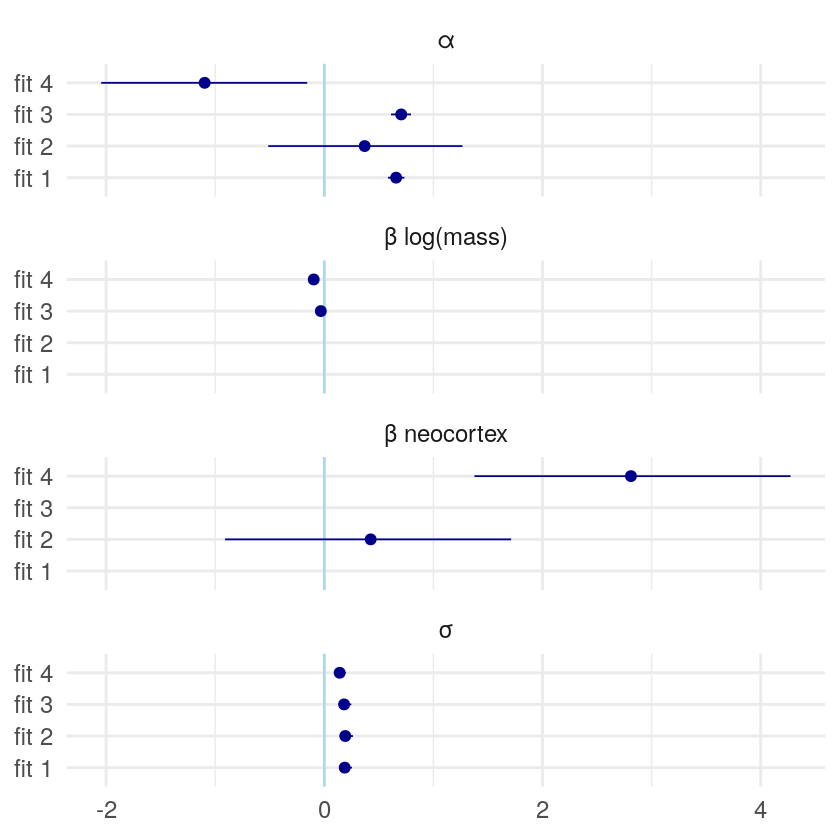

In [31]:
# 14
rbind(
    tidy(fit1) %>% filter(term != "lp__") %>% add_column(model = "fit 1", .before = 1),
    tidy(fit2) %>% filter(term != "lp__") %>% add_column(model = "fit 2", .before = 1),
    tidy(fit3) %>% filter(term != "lp__") %>% add_column(model = "fit 3", .before = 1),
    tidy(fit4) %>% filter(term != "lp__") %>% add_column(model = "fit 4", .before = 1)) %>%
ggplot(aes(x = model, y = estimate, ymin = lower, ymax = upper)) + 
geom_hline(yintercept = 0, colour = "lightblue", size = .75) + 
geom_pointrange(colour = "darkblue") + coord_flip() + facet_wrap(.~ term, ncol = 1,
labeller = labeller(term = c("b_Intercept" = "α",
                            "b_neocortex" = "β neocortex",
                            "b_logmass" = "β log(mass)",
                            "sigma" = "σ"))) + 
theme_minimal(18) + labs(x = NULL, y = NULL)


We can now use the `waic()` function to get the WAIC for each model. We can also save the WAIC estimate into the model itself using the `add_criterion()` function, so we'll do that to. And we'll also get each models LOOIC

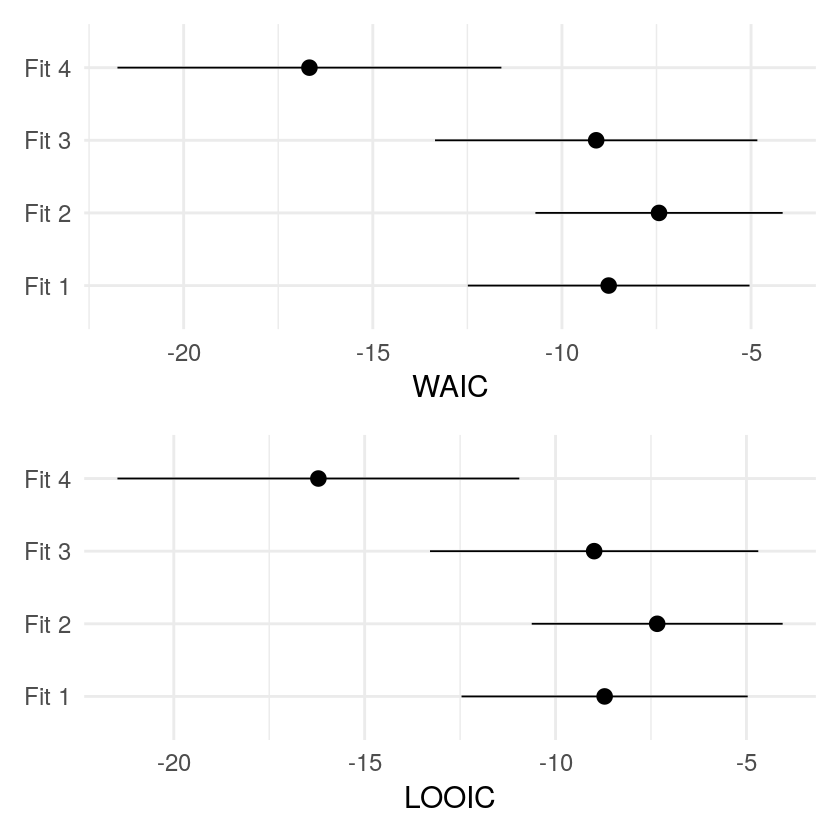

In [32]:
# 15

# add the criterion

fit1 = add_criterion(fit1,c("waic","loo"))
fit2 = add_criterion(fit2,c("waic","loo"))
fit3 = add_criterion(fit3,c("waic","loo"))
fit4 = add_criterion(fit4,c("waic","loo"))#, reloo = T)


# make a list of the WAICs and LOOs
model_list = list(fit1,fit2,fit3,fit4)
model_names = c("Fit 1","Fit 2","Fit 3","Fit 4")

WAICs = map_df(model_list, function(x) waic(x) %>% .[["estimates"]] %>% as.data.frame() %>% as_tibble() %>% slice(3)) %>%
       add_column(fit = model_names, .before = 1)



LOOs = map_df(model_list, function(x) loo(x) %>% .[["estimates"]] %>% as.data.frame() %>% as_tibble() %>% slice(3)) %>%
       add_column(fit = model_names, .before = 1)

# draw some plots 
              
WAIC_plot = ggplot(WAICs, mapping = aes(y = fit, x = Estimate, 
                            xmin = Estimate - SE,
                            xmax = Estimate + SE)) + 
geom_point(size = 4) + geom_errorbarh(height = 0) +
theme_minimal(18) +
labs(y = NULL, x = "WAIC")

LOO_plot = ggplot(LOOs, mapping = aes(y = fit, x = Estimate, 
                            xmin = Estimate - SE,
                            xmax = Estimate + SE)) + 
geom_point(size = 4) + geom_errorbarh(height = 0) +
theme_minimal(18) +
labs(y = NULL, x = "LOOIC")

WAIC_plot / LOO_plot              


Now that have our estimates of out of sample deviance we can just pick the model that performs best. Let's look at our estimates from all the models, and I'll highlight the estimates from the best performing model. 

Now we could stop there, but it seems silly to put all our metaphorical eggs in one basket. Sure, we have an estimate about which model performs best, but we also have uncertainty about this estimate. Just picking the best model is throwing away this uncertainty. So what we'll try and do is preserve this uncertainty. To do this, we'll adopt an approach called **model averaging**. 

However, before we do that, let's just explore the models to see what's going on.

We'll start off just getting a summary and a plot of model 2. We'll use the `fitted()` to get the upper and lower 95% credible interval around our fit.

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: kcal.per.g ~ neocortex 
   Data: milk (Number of observations: 17) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     0.37      0.54    -0.71     1.45 1.00     3174     1987
neocortex     0.43      0.79    -1.13     2.02 1.00     3192     1931

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.19      0.04     0.13     0.28 1.00     2395     2227

Samples were drawn using sampling(NUTS). For each parameter, Eff.Sample 
is a crude measure of effective sample size, and Rhat is the potential 
scale reduction factor on split chains (at convergence, Rhat = 1).

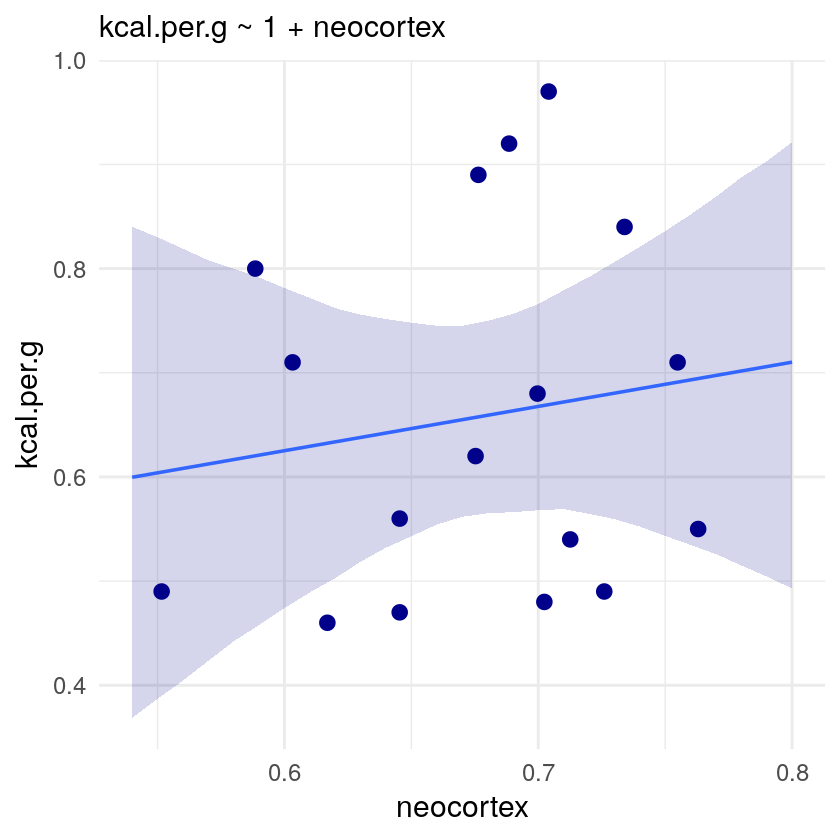

In [38]:
# 16

new_data = tibble(neocortex = seq(0.54,.80,.01))

fitted(fit2, newdata = new_data, probs = c(.025, .975)) %>% as_tibble() %>%
bind_cols(new_data) %>%
ggplot(aes(x = neocortex, y = Estimate)) + 
geom_smooth(aes(ymin = Q2.5, ymax = Q97.5), 
            stat = "identity",
            alpha = 1/6, fill = "darkblue") + 
geom_point(data = milk, aes(x = neocortex, y = kcal.per.g), size = 4, colour = "darkblue") +
theme_minimal(18) + 
labs(y = "kcal.per.g", subtitle = "kcal.per.g ~ 1 + neocortex")
summary(fit2)

And then we'll do the same from model 3.


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: kcal.per.g ~ log(mass) 
   Data: milk (Number of observations: 17) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     0.70      0.06     0.59     0.81 1.00     3291     2463
logmass      -0.03      0.02    -0.08     0.02 1.00     3318     2269

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.18      0.04     0.13     0.26 1.00     2614     2638

Samples were drawn using sampling(NUTS). For each parameter, Eff.Sample 
is a crude measure of effective sample size, and Rhat is the potential 
scale reduction factor on split chains (at convergence, Rhat = 1).

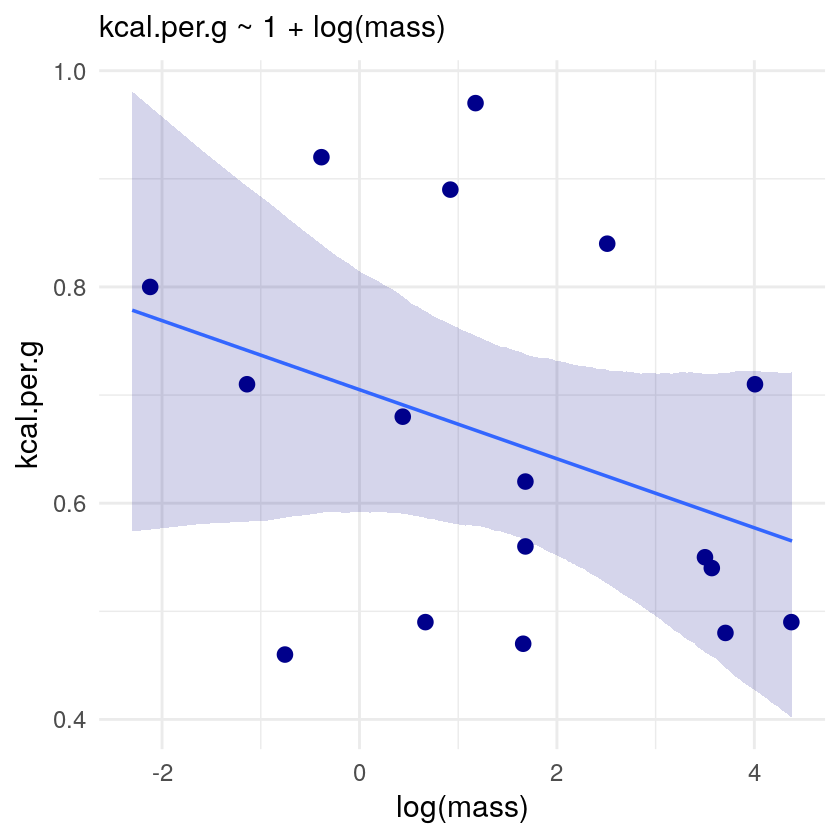

In [39]:
# 17
new_data = tibble(mass = seq(0.10,80,.1))

fitted(fit3, newdata = new_data, probs = c(.025, .975)) %>% as_tibble() %>%
bind_cols(new_data) %>%
ggplot(aes(x = log(mass), y = Estimate)) + 
geom_smooth(aes(ymin = Q2.5, ymax = Q97.5), 
            stat = "identity",
            alpha = 1/6, fill = "darkblue") + 
geom_point(data = milk, aes(x = log(mass), y = kcal.per.g), size = 4, colour = "darkblue") +
theme_minimal(18) + 
labs(y = "kcal.per.g", subtitle = "kcal.per.g ~ 1 + log(mass)")

summary(fit3)

For model 4 things get a little trickier, because we have two predictors. One way I like to deal with a situation like this is to plot the effect of predictor 1 at the average of predictor 2, and vice versa. 


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: kcal.per.g ~ neocortex + log(mass) 
   Data: milk (Number of observations: 17) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept    -1.10      0.58    -2.26     0.05 1.00     2265     2217
neocortex     2.81      0.91     1.01     4.63 1.00     2205     2096
logmass      -0.10      0.03    -0.15    -0.04 1.00     2083     2181

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.14      0.03     0.10     0.22 1.00     2383     2372

Samples were drawn using sampling(NUTS). For each parameter, Eff.Sample 
is a crude measure of effective sample size, and Rhat is the potential 
scale reduction factor on split chains (at convergence, Rhat = 1).

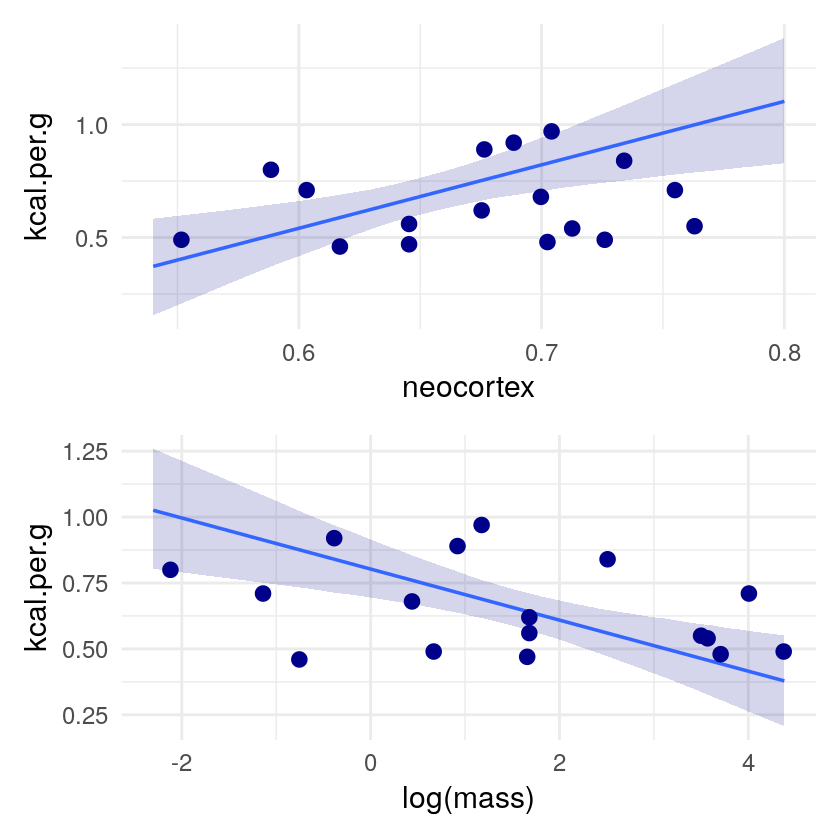

In [40]:
# 18



# make plot one for fit 4

new_data1 = tibble(neocortex = seq(0.54,.80,.01), 
                 mass = median(log(milk$mass)))

fit4_plot1 = fitted(fit4, newdata = new_data1, probs = c(.025, .975)) %>% as_tibble() %>%
bind_cols(new_data1) %>% ggplot(aes(x = neocortex, y = Estimate)) + 
geom_smooth(aes(ymin = Q2.5, ymax = Q97.5), 
            stat = "identity",
            alpha = 1/6, fill = "darkblue") + 
geom_point(data = milk, aes(x = neocortex, y = kcal.per.g), size = 4, colour = "darkblue") +
theme_minimal(18) + 
labs(y = "kcal.per.g")


# make plot two for fit 4
new_data2 = tibble(mass = seq(0.10,80,.1),
                 neocortex = mean(milk$neocortex))

fit4_plot2 = fitted(fit4, newdata = new_data2, probs = c(.025, .975)) %>% as_tibble() %>%
bind_cols(new_data2) %>%
ggplot(aes(x = log(mass), y = Estimate)) + 
geom_smooth(aes(ymin = Q2.5, ymax = Q97.5), 
            stat = "identity",
            alpha = 1/6, fill = "darkblue") + 
geom_point(data = milk, aes(x = log(mass), y = kcal.per.g), size = 4, colour = "darkblue") +
theme_minimal(18) + 
labs(y = "kcal.per.g")



fit4_plot1 / fit4_plot2

summary(fit4)

Up till now we've just being using `fitted()` to plot the uncertainty around the fixed coefficients, but there's uncertainty in our various parameter. We can use the `predict()` function to also include that uncertainty in our plot. 


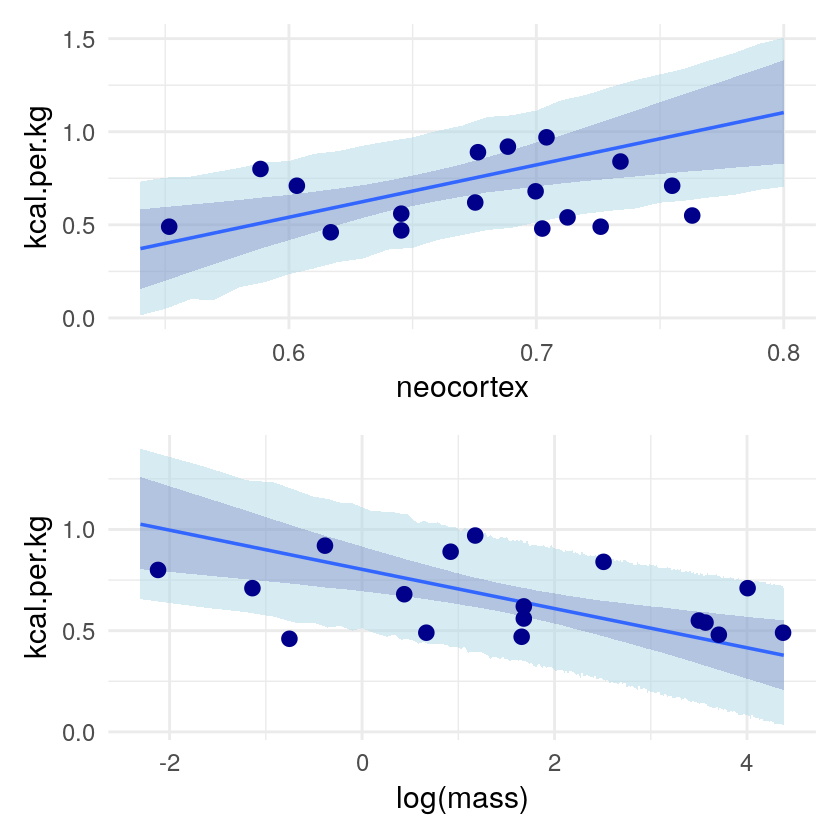

In [41]:
# 19

# since plot and predict name their coloumns in the same way, 
# we'll wrap them both in a little function

fit_and_predict = function(obj, newdata, probs){
    
    fit_interval = fitted(obj, newdata = newdata, probs = probs) %>% 
        as_tibble()
    
    fit_names = fit_interval %>% names() %>% paste0(.,'_fit')
    names(fit_interval) = fit_names
    
    
    predict_interval = predict(obj, newdata = newdata, probs = probs) %>% 
        as_tibble() 
    predict_names = predict_interval %>% names() %>% paste0(.,'_predict')
    names(predict_interval) = predict_names
    
    
    return(bind_cols(newdata,fit_interval, predict_interval))
}

predict4_plot1 = fit_and_predict(fit4, newdata = new_data1, probs = c(0.025,0.975)) %>%
ggplot(aes(x = neocortex, y = Estimate_fit)) +
geom_ribbon(aes(ymin = Q2.5_predict, ymax = Q97.5_predict), fill = "lightblue", alpha = 1/2) +
geom_smooth(aes(ymin = Q2.5_fit, ymax = Q97.5_fit), stat = "identity", fill = "darkblue", alpha = 1/6) +
geom_point(milk, mapping = aes(x = neocortex, y = kcal.per.g), size = 4, colour = "darkblue") + 
theme_minimal(18) + labs(y = "kcal.per.kg", x = "neocortex")


predict4_plot2 = fit_and_predict(fit4, newdata = new_data2, probs = c(0.025,0.975)) %>%
ggplot(aes(x = log(mass), y = Estimate_fit)) +
geom_ribbon(aes(ymin = Q2.5_predict, ymax = Q97.5_predict), fill = "lightblue", alpha = 1/2) +
geom_smooth(aes(ymin = Q2.5_fit, ymax = Q97.5_fit), stat = "identity", fill = "darkblue", alpha = 1/6) +
geom_point(milk, mapping = aes(x = log(mass), y = kcal.per.g), size = 4, colour = "darkblue") + 
theme_minimal(18) + labs(y = "kcal.per.kg", x = "log(mass)")


predict4_plot1 / predict4_plot2

We might also want to include a plot showing our model predictions against the observed values, together with the uncertainty around those predictions.


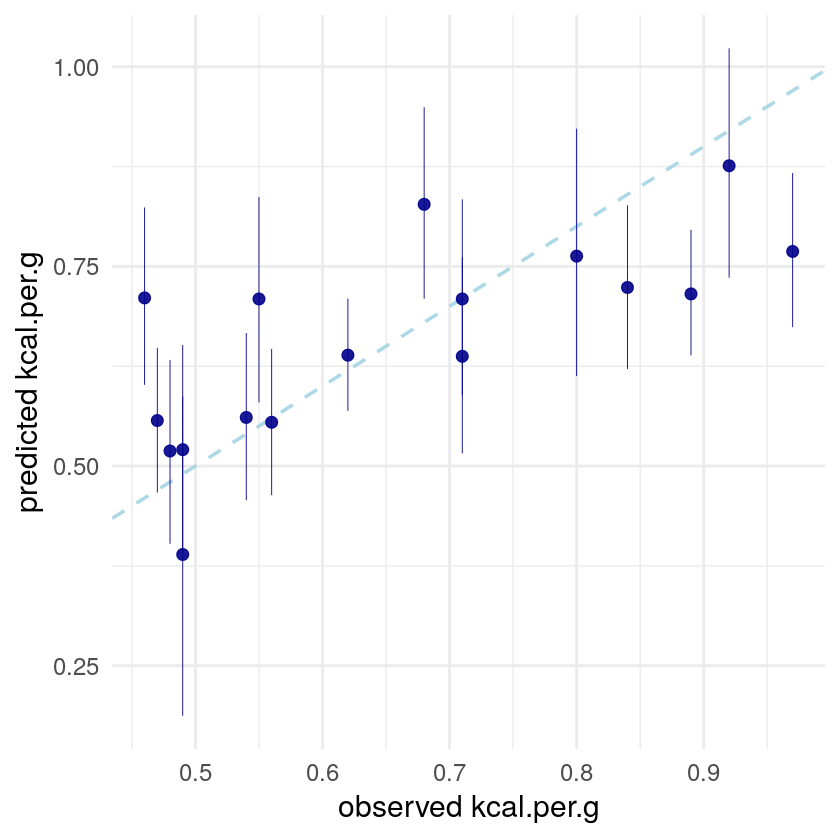

In [42]:
# 20

bind_cols(as_tibble(fitted(fit4)),milk) %>% ggplot(aes(x = kcal.per.g, y = Estimate)) +
geom_abline(linetype = 2, colour = "lightblue", size = 1) +
geom_point(size = 3, colour = "darkblue", alpha = .9) + 
geom_linerange(aes(ymin = Q2.5, ymax = Q97.5), colour = "darkblue", size = .25) + 
theme_minimal(18) + labs(y = "predicted kcal.per.g", x = "observed kcal.per.g")

Or we might want to plot those model predictions in terms of the difference between the predicted value and the observed value (that is, the residuals). And we can include the uncertainty from the fixed coefficients or all the uncertainty. 


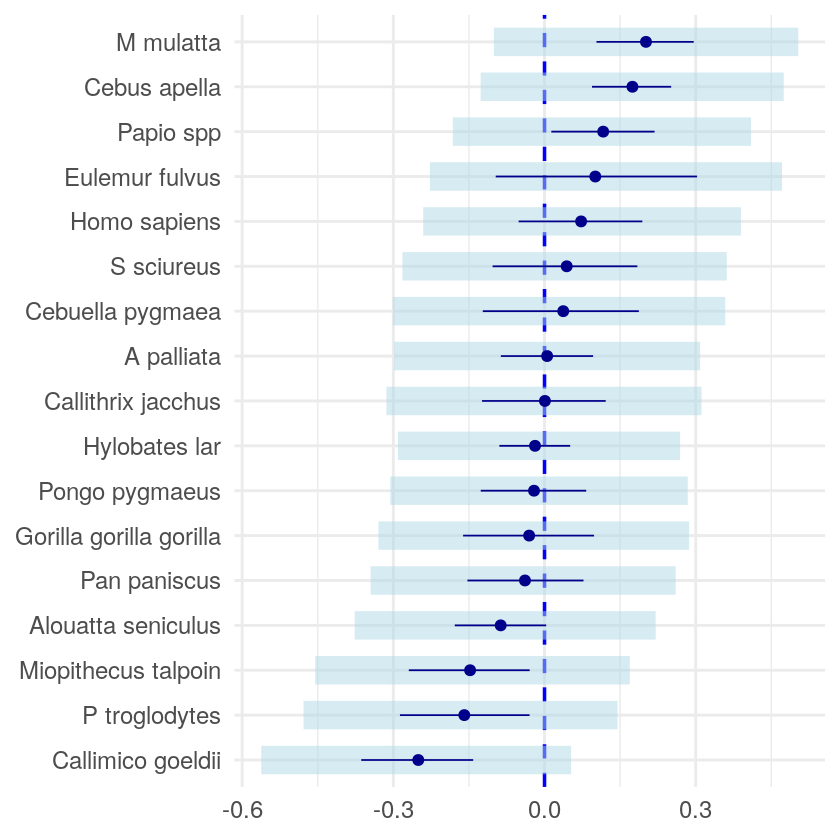

In [43]:
# 21

residuals(fit4) %>% as_tibble() %>% rename(fit_ll = Q2.5, fit_ul = Q97.5) %>%
bind_cols(predict(fit4) %>% as_tibble() %>% transmute(predict_ll = Q2.5, predict_ul = Q97.5),
         milk) %>%
mutate(predict_ll = kcal.per.g - predict_ll, predict_ul = kcal.per.g - predict_ul) %>%


ggplot(aes(x = reorder(species,Estimate), y = Estimate)) +
geom_hline(yintercept = 0, linetype = 2, color = "blue", size = 1) + 
geom_segment(aes(y = predict_ll, 
                 yend = predict_ul, 
                 x = reorder(species,Estimate), 
                 xend = species), colour = "lightblue", size = 8, alpha = .5) +
geom_pointrange(aes(x = reorder(species,Estimate), 
                    ymin = fit_ll, ymax = fit_ul), colour = "darkblue") +
coord_flip() + labs(y = NULL, x = NULL) +
theme_minimal(18)

## Model averaging

The uncertainty in the model isn't our only source of uncertainty. We also had uncertainty about which model was best. Model 4 received the lowest LOO and WAIC score, but how to we know it's low enough? There was uncertainty around around LOO and WAIC estimates, so many the choice isn't so clear cut. Instead of giving undue certainty to our model selection, we can combine the models together through model **averaging**. When we **average** the models together we can **weight** that average by predicted out-of-sample performance. The **brms** package comes with the function called `pp_average()` which will allow us to average our models together using weights derived from our chosen metric (waic or loo). 

We can plot our model averaged uncertainty together with our uncertainty from our best model. 

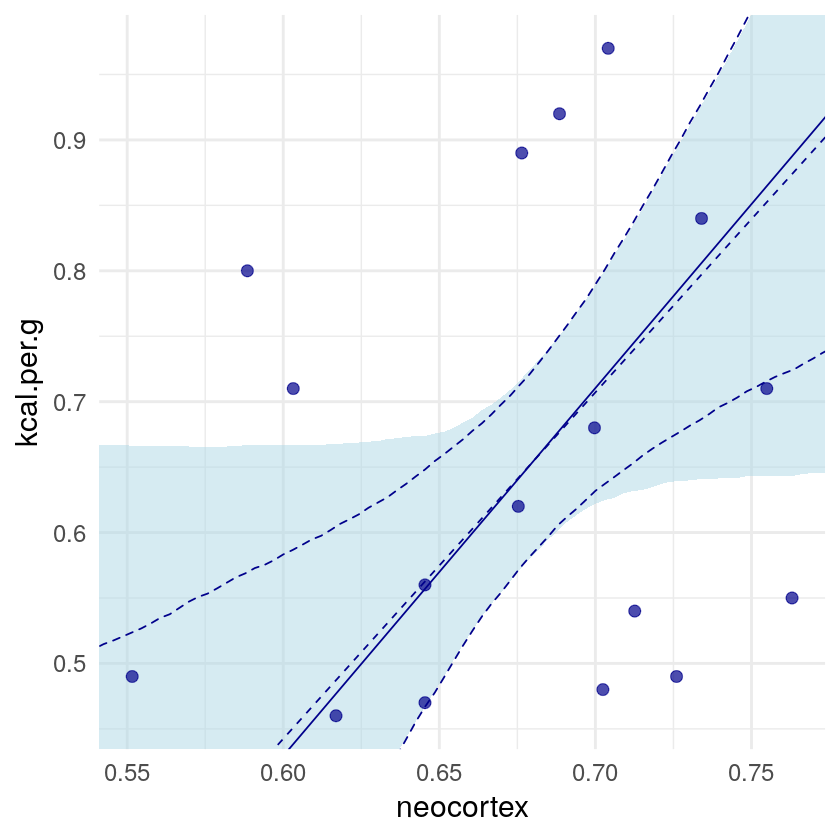

In [47]:
# 22
new_data = tibble(neocortex = seq(0.5,.8, length.out = 100),
                 mass = median(milk$mass))

fit4_fitted = fitted(fit4, newdata = new_data) %>% 
as_tibble() %>% bind_cols(new_data)

average_fitted_loo= pp_average(fit1,fit2,fit3,fit4, weights = "loo", method = "fitted", newdata = new_data) %>% 
as_tibble() %>% bind_cols(new_data)

average_fitted_waic = pp_average(fit1,fit2,fit3,fit4, weights = "waic", method = "fitted", newdata = new_data) %>% 
as_tibble() %>% bind_cols(new_data)

ggplot() +
# model averages
geom_ribbon(average_fitted_loo, mapping = aes(x = neocortex, ymin = Q2.5, ymax = Q97.5), 
            alpha = .5, fill = "lightblue") + 
geom_line(average_fitted_loo, mapping = aes(x = neocortex, y = Estimate), linetype = 2, color = "darkblue", size = .5) + 
# model 4 (best model)
geom_ribbon(fit4_fitted, mapping = aes(x = neocortex, ymin = Q2.5, ymax = Q97.5), 
            alpha = .5, fill = "transparent", linetype = 2, color = "darkblue") + 
geom_line(fit4_fitted, mapping = aes(x = neocortex, y = Estimate), linetype = 1, color = "darkblue", size = .5)  + 
# data points
geom_point(milk, mapping = aes(x = neocortex, y = kcal.per.g), size = 3, colour = "darkblue", alpha = .7) + 
theme_minimal(18) + labs(y = "kcal.per.g") + 
coord_cartesian(ylim = range(milk$kcal.per.g), xlim = range(milk$neocortex))